In [3]:
import sys
import os

import time
import glob 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

from torchvision import transforms
from torchvision.io import read_image

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
import torch
from torchvision import transforms

class MinMaxScaler:
    def __init__(self, min_value=0.0, max_value=1.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, tensor):
        min_val = tensor.min()
        max_val = tensor.max()
        # Apply Min-Max Scaling: (tensor - min) / (max - min)
        return (tensor - min_val) / (max_val - min_val + 1e-7) * (self.max_value - self.min_value) + self.min_value

# Example usage in a transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert PIL images to PyTorch tensors
    MinMaxScaler(min_value=0.0, max_value=1.0)  # Apply Min-Max normalization
])

# Example dataset usage
# dataset = CustomImageDataset(folder_path="path/to/data", transform=transform)


In [6]:

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None, target_transform=None):

        self.img_labels = []
        self.img_paths = []
        self.transform = transform
        self.target_transform = target_transform

        # Map class names to numerical labels
        self.classes = [
            'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
            'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
            'Scentless Mayweed', 'Shepherds Purse', 
            'Small-flowered Cranesbill', 'Sugar beet'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Traverse folder structure
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                label = self.class_to_idx[class_name]
                for img_file in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_file)
                    if img_path.endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
                        self.img_paths.append(img_path)
                        self.img_labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    
# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # Resize images to a fixed size
#     transforms.ToTensor()          # Convert PIL images to PyTorch tensors
# ])

In [7]:
train_folder = './Data/train'
val_folder = './Data/validation'
test_folder = './Data/test'

train_dataset = CustomImageDataset(train_folder, transform=transform)
test_dataset = CustomImageDataset(test_folder, transform=transform)
val_dataset = CustomImageDataset(val_folder, transform=transform)

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)    
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)    

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
learning_rate = 0.0001
batch_size = 64
epochs = 5

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.layer  = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),        

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),        

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride= 1,padding = 'same', bias = True),
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2,stride=2),
    )

        self.fc_layer = nn.Sequential(
            nn.Linear(2 * 2 * 512, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 12),
        )

    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        # self.fc_layer 정의한 연산 수행    
        out = self.fc_layer(out)
        return out

In [11]:
# Define the model
model = NeuralNetwork().to(device)

In [12]:
# 손실 함수를 초기화합니다.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        test_loss, correct = 0, 0


        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        correct /= size
        if batch % 64 == 0:
            loss = loss.item()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss = loss_fn(pred, y)
            print(f"train loss: {loss:.03f} train accuracy {correct:>5d}/{size:>5d}]")

    return loss


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch, (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):0.2f}, Avg loss: {test_loss:>8f} \n")

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):0.2f}, Avg loss: {test_loss:>8f} \n")

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
learning_rate = 0.0001
batch_size = 64
n_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(n_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    for X_train_batch, Y_train_batch in train_dataloader:
        X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_train_batch)
        loss = criterion(outputs, Y_train_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == Y_train_batch).sum().item()

    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataset)
    loss_train_history.append(train_loss)
    acc_train_history.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_dataloader:
            X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)

            outputs = model(X_val_batch)
            loss = criterion(outputs, Y_val_batch)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == Y_val_batch).sum().item()

    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / len(val_dataset)
    loss_val_history.append(val_loss)
    acc_val_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, "
          f"Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}")

# Testing phase
model.eval()
total_test_correct = 0
with torch.no_grad():
    for X_test_batch, Y_test_batch in test_dataloader:
        X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)

        outputs = model(X_test_batch)
        _, predicted = torch.max(outputs, 1)
        total_test_correct += (predicted == Y_test_batch).sum().item()

test_accuracy = total_test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")


Epoch 1/10, Train Loss: 2.427, Train Accuracy: 0.133, Val Loss: 2.477, Val Accuracy: 0.116
Epoch 2/10, Train Loss: 2.416, Train Accuracy: 0.135, Val Loss: 2.468, Val Accuracy: 0.116
Epoch 3/10, Train Loss: 2.391, Train Accuracy: 0.144, Val Loss: 2.540, Val Accuracy: 0.116
Epoch 4/10, Train Loss: 2.374, Train Accuracy: 0.158, Val Loss: 2.358, Val Accuracy: 0.132
Epoch 5/10, Train Loss: 2.294, Train Accuracy: 0.192, Val Loss: 2.241, Val Accuracy: 0.228
Epoch 6/10, Train Loss: 2.099, Train Accuracy: 0.269, Val Loss: 1.869, Val Accuracy: 0.336
Epoch 7/10, Train Loss: 1.580, Train Accuracy: 0.461, Val Loss: 1.860, Val Accuracy: 0.345
Epoch 8/10, Train Loss: 1.352, Train Accuracy: 0.527, Val Loss: 1.211, Val Accuracy: 0.550
Epoch 9/10, Train Loss: 1.209, Train Accuracy: 0.584, Val Loss: 1.224, Val Accuracy: 0.579
Epoch 10/10, Train Loss: 1.097, Train Accuracy: 0.613, Val Loss: 1.010, Val Accuracy: 0.624
Test Accuracy: 0.632


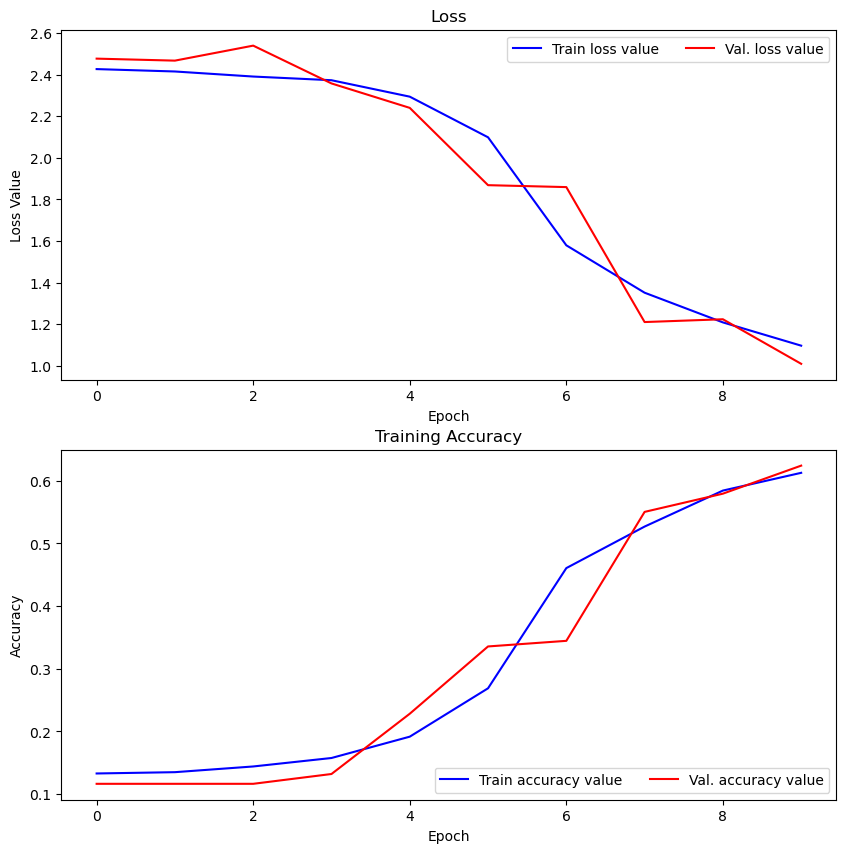

In [16]:
plt.subplot(2,1,1)
plt.plot(loss_train_history, 'b-', label='Train loss value')
plt.plot(loss_val_history, 'r-', label='Val. loss value')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(ncol=2, loc='upper right')

plt.subplot(2,1,2)
plt.plot(acc_train_history, 'b-', label='Train accuracy value')
plt.plot(acc_val_history, 'r-', label='Val. accuracy value')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 10)
plt.show()